## Conditional function

In [7]:

# Define a function for custom max value selection
def find_max_values(batch):
    length = len(batch)
    if length in [4, 5, 6]:  # Special case for lengths 4, 5, and 6
        # Find max value from the first 3 elements
        max_first_part = max(batch[:3])
        # Find max value from the remaining elements
        max_second_part = max(batch[3:]) if length > 3 else None
        return [max_first_part, max_second_part] if max_second_part is not None else [max_first_part]
    elif length in [7, 8, 9]:  # Special case for lengths 8 and 9
        # Max from the first 3 values
        max_first_part = max(batch[:3])
        # Max from the next 3 values
        max_second_part = max(batch[3:6])
        # Max from the remaining values
        max_remaining = max(batch[6:]) if length > 6 else None
        return [max_first_part, max_second_part, max_remaining] if max_remaining is not None else [max_first_part, max_second_part]
    elif length == 1:  # Special case for length 1
        return batch  # Return the single value as is
    elif length == 3:  # Special case for length 3
        return [max(batch)]  # Return the maximum of the batch
    else:  # Default case (no special rule)
        return [max(batch)]  # Return the overall max

def rx_data(value_p):
    s_batch = []
    rx_mess = []
    len_b = []
    start_idx = None
    for i, avg_pixel in enumerate(value_p):
        int_avg = int(avg_pixel)
        if int_avg == 0:
            if start_idx is not None and start_idx<i:
                b_in_b = value_p[start_idx:i]
                # call the max value function
                max1_values = find_max_values(b_in_b)
                rx_mess.append(max1_values)
                s_batch.append(b_in_b)
                len_b.append(len(b_in_b))
            start_idx = None
        else:
            if start_idx is None:
                start_idx = i

    if start_idx is not None and start_idx<len(value_p):
        bin_b = value_p[start_idx:]
        # call the max value function
        max2_values = find_max_values(bin_b)
        rx_mess.append(max2_values)
        s_batch.append(bin_b)
        len_b.append(len(bin_b))

    # print("batch value_p",s_batch)
    # print("each batch length",len_b)
    # print("rx message",rx_mess)

    # Flatten the list of max values batches and remove brackets/parentheses
    flat_max_values = [value for batch in rx_mess for value in batch]

    if len(flat_max_values)==128:
        # Convert to a space-separated string for cleaner output
        result = flat_max_values
        return result



## data decoding

In [8]:
import numpy as np
from PIL import Image
import os

for k in range(1, 2):
    # Define input and output directories
    input_directory = fr'F:\My File2\OCC_Nov_11\Datasets_L8_8_subcarrier\3_rx_image\m{k}'  # Folder containing the tiff images
    output_directory= fr'F:\My File2\OCC_Nov_11\Datasets_L8_8_subcarrier\4_rx_decoded_data\m{k}'  # Folder to save the decoded data

    # Define the batch size
    batch_size = 128  # Adjust the batch size as per your needs
    # Create the output directory if it doesn't exist
    if not os.path.exists(input_directory):
        os.makedirs(input_directory)

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Get all TIFF files in the input directory
    tiff_files = [f for f in os.listdir(input_directory) if f.endswith('.tiff')]

    # Define the threshold
    threshold = 15.0  # Define threshold for batch separation

    # Loop over all TIFF files in the input directory
    for tiff_file in tiff_files:
        # Load each TIFF image
        image_path = os.path.join(input_directory, tiff_file)
        image = Image.open(image_path)
        image_data = np.array(image).astype(float)

        # Extract specific column range (e.g., columns 850 to 1000)
        columns_range_data = image_data[:, 750:1050]
        column_avg = np.mean(columns_range_data, axis=1)

        # Flatten the array of column-averaged values
        flat_column_avg = column_avg.flatten()
        # print("average value",flat_column_avg)
        # Vnp.savetxt('column_flat_column_avg_values.txt', flat_column_avg, fmt='%.3f')

        # updated_data, removed_indices = remove_consecutive_duplicates(flat_column_avg)
        # print("Updated Data:", updated_data)
        # print("Removed Indices:", removed_indices)
        # Initialize variables for batch creation
        # Initialize variables for batch creation
        batches_column_avg = []  # List to store batches

        l= len(flat_column_avg)
        start_idx = None

        i=0
        while i<l:
            if flat_column_avg[i]==0:
                zero_count =1
                while i+zero_count<l and flat_column_avg[i+zero_count]==0:
                    zero_count+=1
                
                if zero_count>3:
                    if start_idx is not None:
                        batches_column_avg.append(np.round(flat_column_avg[start_idx:i],5))
                        start_idx = None
                    i+= zero_count-1
                else:
                    if start_idx is None:
                        start_idx=i+zero_count
                    i+=zero_count-1
            else:
                if start_idx is None:
                    start_idx = i
            i+=1
        
        if start_idx is not None and start_idx<l:
            batches_column_avg.append(np.round(flat_column_avg[start_idx:],5))

        #print("Batches with Zeros <= 3 Included:", batches_column_avg)

        # Process each batch and average every two pixels, excluding first and last batch
        for i, batch in enumerate(batches_column_avg[0:], start=0): 
            #print(f" Batch {i}: Original Data{np.array(batch).shape}")
            #print(np.array(np.round(batch,4)))  # Print the original batch content
            output_rx = rx_data(batch)
            # Check if the current batch has the required length
            if output_rx is not None:
                if len(output_rx) == batch_size:
                    # Convert list to comma-separated string
                    formatted_list = ', '.join(map(str, output_rx))

                    # Save the batch to a text file (e.g., m1.txt, m2.txt, etc.)
                    output_file_name = os.path.join(output_directory, f"{os.path.splitext(tiff_file)[0]}m{i}.txt")
                    with open(output_file_name, 'w') as file:
                        file.write(f"{formatted_list}")

                    print("rx_message", output_rx)
            
print("Processing complete for all TIFF files.")


rx_message [14.61667, 8.39333, 8.36333, 8.88333, 12.35667, 8.41333, 10.43, 18.43333, 12.22667, 11.62667, 11.61, 11.61333, 14.62, 16.13333, 12.35333, 7.69333, 17.70667, 13.40333, 10.52, 17.47, 9.04333, 8.95, 10.48667, 9.60333, 14.75, 5.08, 12.6, 12.58333, 10.67, 14.37, 12.54, 14.81, 12.64667, 11.36333, 14.95333, 15.60333, 5.91, 7.85333, 12.80333, 9.72333, 15.05333, 13.90333, 12.63667, 12.03, 13.15333, 5.79, 6.70333, 17.10667, 17.02, 10.76667, 6.83333, 12.91, 11.60333, 11.01, 12.82333, 13.64667, 10.91333, 11.57333, 14.04667, 18.48, 17.26, 8.07, 10.99333, 14.20667, 11.43, 18.69333, 13.01333, 11.59, 6.88, 9.99667, 13.32667, 8.04667, 13.09, 16.05333, 15.36667, 14.49333, 13.55, 12.25667, 6.90333, 11.7, 7.0, 10.77333, 17.64333, 15.25667, 15.52333, 9.01667, 11.2, 15.39667, 17.94333, 13.82333, 6.99667, 9.06, 10.61333, 15.74, 13.31, 9.82333, 11.20667, 9.18333, 11.11333, 15.44, 17.58333, 8.81667, 7.01333, 13.2, 8.96667, 11.16667, 13.41333, 19.65667, 11.21333, 11.26, 13.18333, 9.41333, 7.09333, 11

## Message extraction

1/1 [==============================] - 0s 189ms/step


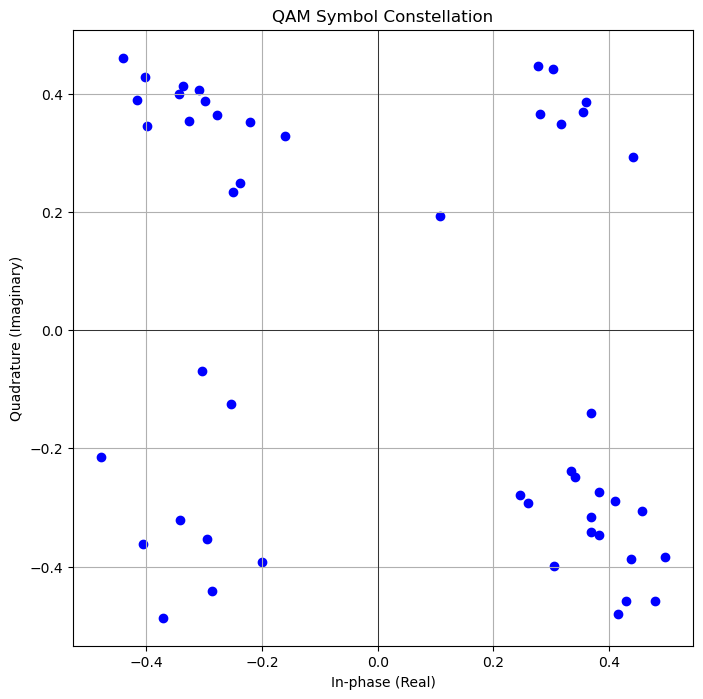

Decoded message: enly, va


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
model_paths = r"F:\My File\unet_signal_prediction_model.h5"

rx_data = np.array([16.22, 12.56, 13.24667, 19.83, 7.11, 5.85, 16.45, 11.24333, 12.31, 19.86333, 14.33, 6.36, 16.41, 12.71, 5.26, 15.26333, 11.94333, 9.51, 16.56667, 21.14, 9.63, 12.01667, 16.77, 7.84, 12.01, 12.07333, 14.24, 11.02, 12.08667, 21.22667, 11.47667, 12.08667, 9.80667, 15.25, 22.31667, 7.75333, 8.23667, 14.87333, 10.47, 11.33, 16.98, 13.35667, 13.69, 13.55333, 14.77333, 10.34333, 7.69667, 18.15667, 14.41, 9.05, 16.24667, 17.82, 16.98667, 17.18667, 5.64, 13.72667, 17.09333, 3.79667, 10.88333, 17.33, 14.48667, 15.67, 24.68, 14.54, 11.28333, 20.78667, 14.67667, 13.95, 7.99, 11.52667, 12.97667, 10.82333, 11.02667, 10.58, 12.42667, 9.13667, 19.77667, 20.77333, 12.29, 11.55667, 17.23333, 18.49, 5.57667, 9.00333, 16.55333, 11.18333, 17.25333, 15.62333, 9.90333, 18.39333, 22.1, 14.64667, 11.02, 6.05, 14.74667, 15.32, 22.91333, 11.39333, 6.86667, 16.15333, 14.63, 16.22333, 17.17333, 8.38667, 8.04, 22.67667, 19.45333, 12.49667, 14.90333, 12.22667, 9.58, 15.2, 7.36333, 7.22667, 20.76667, 15.12667, 13.69667, 11.50333, 11.36, 13.12667, 14.42333, 13.73333, 4.90333, 13.36333, 14.46333, 14.84667, 11.32667, 13.65667])
rx_data.shape

# Scaling function
def scale_data(data):
    return (data - data.min()) / (data.max() - data.min())

# Scale the data
rx_train = scale_data(rx_data)

model = load_model(model_paths)
input_data = rx_train.reshape(-1,1,8,1)
prediction = model.predict(input_data)
rx_reshaped = prediction.reshape(-1, 128)

#rx_reshaped = rx_train.reshape(-1, 128)

# Clip extreme values in each batch
clipped_data = []
for batch in rx_reshaped:
    lower_threshold = np.percentile(batch, 0)
    upper_threshold = np.percentile(batch, 100)
    batch_clipped = np.clip(batch, lower_threshold, upper_threshold)
    clipped_data.append(batch_clipped)
clipped_data = np.array(clipped_data).reshape(-1)  # Flatten back to original shape
# Load the datasets into numpy arrays (assuming they're comma-separated)
clip_rx_data = clipped_data.reshape(-1,128)

# Make the data to complex format
complex_ofdm = clip_rx_data + 0j
# print("Complex OFDM Symbols:")
# print(complex_ofdm)

## perform reshape
ofdm_symbols_reshaped = complex_ofdm.reshape(-1, 8) # change 16 t0 8 for 8 subcarrier
# print(ofdm_symbols_reshaped)

# after fft hermitian symbol created
fft_ofdm_symbols = np.fft.fft(ofdm_symbols_reshaped, axis=1)
# print(fft_ofdm_symbols)
# print(fft_ofdm_symbols.shape)

# File paths for saved models

# hermirian to QAM-4 original signal
def reverse_hermitian_symmetry_matrix(hermitian_symmetric_matrix):
    """Recover the QAM symbols from a matrix of Hermitian-symmetric OFDM symbols.
    Each row of the input matrix represents a 8-subcarrier OFDM symbol.
    """
    num_rows = hermitian_symmetric_matrix.shape[0]  # Get the number of rows
    qam_symbols_matrix = np.zeros((num_rows, 3), dtype=complex)  # Initialize the output array
    
    for i in range(num_rows):
        # Extract the original QAM symbols from each row
        qam_symbols_matrix[i, :] = hermitian_symmetric_matrix[i, 1:4]
    return qam_symbols_matrix

qam_symbols_matrix = reverse_hermitian_symmetry_matrix(fft_ofdm_symbols)
# # Print the recovered QAM symbols for each row
# print(qam_symbols_matrix)

# Concatenate all rows into a single row
QAM_16 = np.concatenate(qam_symbols_matrix)

## QAM constellation for original signal
import numpy as np
import matplotlib.pyplot as plt
# Plot the constellation diagram
plt.figure(figsize=(8, 8))
plt.scatter(QAM_16.real, QAM_16.imag, color='blue', marker='o')
# Add grid lines and labels
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.title("QAM Symbol Constellation")
plt.xlabel("In-phase (Real)")
plt.ylabel("Quadrature (Imaginary)")
# Show the plot
plt.show()

## hermirian to QAM-16 equalize signal
def qam4_to_binary(symbols):
    """Convert QAM-16 symbols back to a binary list, replace unmatched symbols with '1010'."""
    binary_list = []
    for RI in symbols:
        R = np.real(RI)
        I = np.imag(RI)

        if R >=0 and I>=0 :
            binary_list.append('00')
        elif R < 0 and I>=0 :
            binary_list.append('10')
        elif R < 0 and I < 0 :
            binary_list.append('11')
        elif R >=0 and I< 0 :
            binary_list.append('01')
        
    # Join the list of binary strings and convert them into individual bits
    return binary_list

binary_output = qam4_to_binary(QAM_16)
# print("Binary Output:", binary_output)
# Convert list to a single string
binary_string = ''.join(binary_output)
# print(binary_string)

## FEC decoding using reed-solomon decoder
import reedsolo
# Helper function to convert a binary string to bytes
def binary_to_bytes(binary_str):
    return bytes(int(binary_str[i:i+8], 2) for i in range(0, len(binary_str), 8))

# Helper function to convert bytes back to binary string
def bytes_to_binary(byte_data):
    return ''.join(format(byte, '08b') for byte in byte_data)

# Initialize the Reed-Solomon codec
n = 15
k = 11
rs = reedsolo.RSCodec(n - k)
# Convert binary string to bytes
binary_bytes = binary_to_bytes(binary_string)
# Decoding the corrupted data (and correcting errors)
decoded_tuple = rs.decode(binary_bytes)
# Extract the corrected message (first element of the tuple)
corrected_message = decoded_tuple[0]
# Convert the corrected bytes back to binary
decoded_binary = bytes_to_binary(corrected_message)
# print(f"Original Binary Data: {binary_string}")
# print(f"Corrected Binary Data: {decoded_binary}")

## binary to original message
def bits_to_string(bits):
    """Convert a list of bits back to a string."""
    chars = [chr(int(''.join(map(str, bits[i:i + 8])), 2)) for i in range(0, len(bits), 8)]
    return ''.join(chars)

# Convert the binary string to a list of integers (0s and 1s)
corrected_bits = [int(bit) for bit in decoded_binary]
# Convert the bits to the original string
decoded_message = bits_to_string(corrected_bits)
print(f"Decoded message: {decoded_message}")



## ALL message extraction

In [28]:
import os
import numpy as np
import reedsolo

def binary_to_bytes(binary_str):
    return bytes(int(binary_str[i:i+8], 2) for i in range(0, len(binary_str), 8))

def bytes_to_binary(byte_data):
    return ''.join(format(byte, '08b') for byte in byte_data)

def bits_to_string(bits):
    """Convert a list of bits back to a string."""
    chars = [chr(int(''.join(map(str, bits[i:i + 8])), 2)) for i in range(0, len(bits), 8)]
    return ''.join(chars)

def reverse_hermitian_symmetry_matrix(hermitian_symmetric_matrix):
    num_rows = hermitian_symmetric_matrix.shape[0]  
    qam_symbols_matrix = np.zeros((num_rows, 3), dtype=complex)                    
    for i in range(num_rows):
        qam_symbols_matrix[i, :] = hermitian_symmetric_matrix[i, 1:4]
    return qam_symbols_matrix

def qam4_to_binary(symbols):
    """Convert QAM-16 symbols back to a binary list, replace unmatched symbols with '1010'."""
    binary_list = []
    for RI in symbols:
        R = np.real(RI)
        I = np.imag(RI)

        if R >=0 and I>=0 :
            binary_list.append('00')
        elif R < 0 and I>=0 :
            binary_list.append('10')
        elif R < 0 and I < 0 :
            binary_list.append('11')
        elif R >=0 and I< 0 :
            binary_list.append('01')
    return binary_list

# Scaling function
def scale_data(data):
    return (data - data.min()) / (data.max() - data.min())

n = 15
k = 11
rs = reedsolo.RSCodec(n - k)
# File paths for saved models
model_paths = r"F:\My File\unet_signal_prediction_model.h5"

import tensorflow as tf
from tensorflow.keras.models import load_model
model = load_model(model_paths)

folder_path = r"F:\My File\OCC_Nov_11\Datasets_L8_8_subcarrier\7_test_rx_decoded_data\m408"
for file_name in os.listdir(folder_path):
    if file_name.endswith(".txt"):  # Check if the file is a .txt file
        file_path = os.path.join(folder_path, file_name)
        try:
            with open(file_path, 'r') as file:
                lines = file.readlines()  # Read liness
                txt_data = [
                    float(item.strip().strip(','))  # Remove extra spaces/commas and convert to float
                    for line in lines for item in line.split()
                ]
                #print(f"Contents of {file_name}:")
                data = np.array(txt_data)
                #print(data.shape)
                rx_train = data

                # Scale the data
                rx_train = scale_data(data)

                input_data = rx_train.reshape(-1,1,8,1)
                prediction = model.predict(input_data)
                rx_reshaped = prediction.reshape(-1, 128)
                #print(rx_reshaped)
                clipped_data = []
                for batch in rx_reshaped:
                    lower_threshold = np.percentile(batch, 0)
                    upper_threshold = np.percentile(batch, 100)
                    batch_clipped = np.clip(batch, lower_threshold, upper_threshold)
                    clipped_data.append(batch_clipped)
                clipped_data = np.array(clipped_data).reshape(-1) 
                clip_rx_data = clipped_data.reshape(-1,128)
                complex_ofdm = clip_rx_data + 0j
                ofdm_symbols_reshaped = complex_ofdm.reshape(-1, 8) 
                fft_ofdm_symbols = np.fft.fft(ofdm_symbols_reshaped, axis=1)

                qam_symbols_matrix = reverse_hermitian_symmetry_matrix(fft_ofdm_symbols)
                QAM_16 = np.concatenate(qam_symbols_matrix)

                import numpy as np
                import matplotlib.pyplot as plt
                plt.figure(figsize=(8, 8))
                plt.scatter(QAM_16.real, QAM_16.imag, color='blue', marker='o')
                plt.grid(True)
                plt.axhline(0, color='black',linewidth=0.5)
                plt.axvline(0, color='black',linewidth=0.5)
                plt.title("QAM Symbol Constellation")
                plt.xlabel("In-phase (Real)")
                plt.ylabel("Quadrature (Imaginary)")
                plt.show()

                binary_output = qam4_to_binary(QAM_16)
                binary_string = ''.join(binary_output)
                print(binary_string)
                try:
                    binary_bytes = binary_to_bytes(binary_string)
                    decoded_tuple = rs.decode(binary_bytes)
                    corrected_message = decoded_tuple[0]
                    decoded_binary = bytes_to_binary(corrected_message)
                
                    corrected_bits = [int(bit) for bit in decoded_binary]
                    decoded_message = bits_to_string(corrected_bits)
                    if decoded_message:  # Only print if a message is successfully decoded
                        print(f"Decoded message from {file_name}: {decoded_message}")
                except:
                    pass

        except:
            pass


1/1 [==============================] - 0s 172ms/step
011001010101001000100000011000110110000101110011011101000110100100011001010010001011100110110011
Decoded message from 1m1.txt: er casti
1/1 [==============================] - 0s 23ms/step
011001010111001000100000011000110110000101110011011101000110100100011001010010001011100110011001
Decoded message from 2m1.txt: er casti
1/1 [==============================] - 0s 24ms/step
111000010111000000100010010000110110001101110011011101000110100100011001010010001011100110110011
1/1 [==============================] - 0s 26ms/step
011001010111001000100000011000110110000101110011011101000110100100011001010010001011100110110011
Decoded message from 4m1.txt: er casti
1/1 [==============================] - 0s 25ms/step
011001010111001000100000011010110110000101110011011101000110100100011001010010001011100110110011
Decoded message from 5m1.txt: er casti
1/1 [==============================] - 0s 24ms/step
0110010101110010001000000110101101100001011100

In [2]:
pip install reedsolo


  Using cached reedsolo-1.7.0-py3-none-any.whl (32 kB)
Note: you may need to restart the kernel to use updated packages.


In [20]:
import os
import numpy as np
import reedsolo

def binary_to_bytes(binary_str):
    return bytes(int(binary_str[i:i+8], 2) for i in range(0, len(binary_str), 8))

def bytes_to_binary(byte_data):
    return ''.join(format(byte, '08b') for byte in byte_data)

def bits_to_string(bits):
    """Convert a list of bits back to a string."""
    chars = [chr(int(''.join(map(str, bits[i:i + 8])), 2)) for i in range(0, len(bits), 8)]
    return ''.join(chars)

def reverse_hermitian_symmetry_matrix(hermitian_symmetric_matrix):
    num_rows = hermitian_symmetric_matrix.shape[0]  
    qam_symbols_matrix = np.zeros((num_rows, 3), dtype=complex)                    
    for i in range(num_rows):
        qam_symbols_matrix[i, :] = hermitian_symmetric_matrix[i, 1:4]
    return qam_symbols_matrix

def qam4_to_binary(symbols):
    """Convert QAM-16 symbols back to a binary list, replace unmatched symbols with '1010'."""
    binary_list = []
    for RI in symbols:
        R = np.real(RI)
        I = np.imag(RI)

        if R >=0 and I>=0 :
            binary_list.append('00')
        elif R < 0 and I>=0 :
            binary_list.append('10')
        elif R < 0 and I < 0 :
            binary_list.append('11')
        elif R >=0 and I< 0 :
            binary_list.append('01')
    return binary_list

n = 15
k = 11
rs = reedsolo.RSCodec(n - k)

def message_extract_code(rx_message):
    decoded_message = []
    debug_info = []

    for batch in rx_message:
        try:
            lines = batch.readlines()  # Read liness
            txt_data = [
                float(item.strip().strip(','))  # Remove extra spaces/commas and convert to float
                for line in lines for item in line.split()
            ]
                #print(f"Contents of {file_name}:")
            data = np.array(txt_data)
            #data = np.array(batch)
            #print(data.shape)
            rx_train = data
            rx_reshaped = rx_train.reshape(-1, 128)
            clipped_data = []
            for batch in rx_reshaped:
                lower_threshold = np.percentile(batch, 0)
                upper_threshold = np.percentile(batch, 100)
                batch_clipped = np.clip(batch, lower_threshold, upper_threshold)
                clipped_data.append(batch_clipped)
            clipped_data = np.array(clipped_data).reshape(-1) 
            clip_rx_data = clipped_data.reshape(-1,128)
            complex_ofdm = clip_rx_data + 0j
            ofdm_symbols_reshaped = complex_ofdm.reshape(-1, 8) 
            fft_ofdm_symbols = np.fft.fft(ofdm_symbols_reshaped, axis=1)

            qam_symbols_matrix = reverse_hermitian_symmetry_matrix(fft_ofdm_symbols)
            QAM_16 = np.concatenate(qam_symbols_matrix)
            # import numpy as np
            # import matplotlib.pyplot as plt
            # plt.figure(figsize=(8, 8))
            # plt.scatter(QAM_16.real, QAM_16.imag, color='blue', marker='o')
            # plt.grid(True)
            # plt.axhline(0, color='black',linewidth=0.5)
            # plt.axvline(0, color='black',linewidth=0.5)
            # plt.title("QAM Symbol Constellation")
            # plt.xlabel("In-phase (Real)")
            # plt.ylabel("Quadrature (Imaginary)")
            # plt.show()

            binary_output = qam4_to_binary(QAM_16)
            binary_string = ''.join(binary_output)
            try:
                binary_bytes = binary_to_bytes(binary_string)
                decoded_tuple = rs.decode(binary_bytes)
                corrected_message = decoded_tuple[0]
                decoded_binary = bytes_to_binary(corrected_message)
            
                corrected_bits = [int(bit) for bit in decoded_binary]
                decoded_message = bits_to_string(corrected_bits)
                # Collect debug info
                debug_info.append({
                    "binary_output": binary_output,
                    "decoded_binary": decoded_binary,
                    "corrected_bits": corrected_bits,
                    "decoded_message": decoded_message
                })

                if decoded_message:  # Only print if a message is successfully decoded
                    print(f"Decoded message from : {decoded_message}")
            except Exception as e:
                print(f"Error during decoding: {e}")
                pass

        except:
            pass
    
    return decoded_message, debug_info


In [12]:

import numpy as np
from PIL import Image
import os
#from message_extraction import message_extract_code  # Import from the second .py file
import reedsolo

def binary_to_bytes(binary_str):
    return bytes(int(binary_str[i:i+8], 2) for i in range(0, len(binary_str), 8))

def bytes_to_binary(byte_data):
    return ''.join(format(byte, '08b') for byte in byte_data)

def bits_to_string(bits):
    """Convert a list of bits back to a string."""
    chars = [chr(int(''.join(map(str, bits[i:i + 8])), 2)) for i in range(0, len(bits), 8)]
    return ''.join(chars)

def reverse_hermitian_symmetry_matrix(hermitian_symmetric_matrix):
    num_rows = hermitian_symmetric_matrix.shape[0]  
    qam_symbols_matrix = np.zeros((num_rows, 3), dtype=complex)                    
    for i in range(num_rows):
        qam_symbols_matrix[i, :] = hermitian_symmetric_matrix[i, 1:4]
    return qam_symbols_matrix

def qam4_to_binary(symbols):
    """Convert QAM-16 symbols back to a binary list, replace unmatched symbols with '1010'."""
    binary_list = []
    for RI in symbols:
        R = np.real(RI)
        I = np.imag(RI)

        if R >=0 and I>=0 :
            binary_list.append('00')
        elif R < 0 and I>=0 :
            binary_list.append('10')
        elif R < 0 and I < 0 :
            binary_list.append('11')
        elif R >=0 and I< 0 :
            binary_list.append('01')
    return binary_list

n = 15
k = 11
rs = reedsolo.RSCodec(n - k)

# Define a function for custom max value selection
def find_max_values(batch):
    length = len(batch)
    if length in [4, 5, 6]:  # Special case for lengths 4, 5, and 6
        # Find max value from the first 3 elements
        max_first_part = max(batch[:3])
        # Find max value from the remaining elements
        max_second_part = max(batch[3:]) if length > 3 else None
        return [max_first_part, max_second_part] if max_second_part is not None else [max_first_part]
    elif length in [7, 8, 9]:  # Special case for lengths 8 and 9
        # Max from the first 3 values
        max_first_part = max(batch[:3])
        # Max from the next 3 values
        max_second_part = max(batch[3:6])
        # Max from the remaining values
        max_remaining = max(batch[6:]) if length > 6 else None
        return [max_first_part, max_second_part, max_remaining] if max_remaining is not None else [max_first_part, max_second_part]
    elif length == 1:  # Special case for length 1
        return batch  # Return the single value as is
    elif length == 3:  # Special case for length 3
        return [max(batch)]  # Return the maximum of the batch
    else:  # Default case (no special rule)
        return [max(batch)]  # Return the overall max

def rx_data(value_p):
    s_batch = []
    rx_mess = []
    len_b = []
    start_idx = None
    for i, avg_pixel in enumerate(value_p):
        int_avg = int(avg_pixel)
        if int_avg == 0:
            if start_idx is not None and start_idx<i:
                b_in_b = value_p[start_idx:i]
                # call the max value function
                max1_values = find_max_values(b_in_b)
                rx_mess.append(max1_values)
                s_batch.append(b_in_b)
                len_b.append(len(b_in_b))
            start_idx = None
        else:
            if start_idx is None:
                start_idx = i

    if start_idx is not None and start_idx<len(value_p):
        bin_b = value_p[start_idx:]
        # call the max value function
        max2_values = find_max_values(bin_b)
        rx_mess.append(max2_values)
        s_batch.append(bin_b)
        len_b.append(len(bin_b))

    # print("batch value_p",s_batch)
    # print("each batch length",len_b)
    # print("rx message",rx_mess)

    # Flatten the list of max values batches and remove brackets/parentheses
    flat_max_values = [value for batch in rx_mess for value in batch]

    if len(flat_max_values)==128:
        # Convert to a space-separated string for cleaner output
        result = flat_max_values
        return result

def process_image(image_data): # directly data array is transfered fron another .py file
    batch_size = 128

    # Extract specific column range (e.g., columns 850 to 1000)
    columns_range_data = image_data[:, 750:1050]
    column_avg = np.mean(columns_range_data, axis=1)

    # Flatten the array of column-averaged values
    flat_column_avg = column_avg.flatten()
    batches_column_avg = []  # List to store batches

    l= len(flat_column_avg)
    start_idx = None

    i=0
    while i<l:
        if flat_column_avg[i]==0:
            zero_count =1
            while i+zero_count<l and flat_column_avg[i+zero_count]==0:
                zero_count+=1
            
            if zero_count>3:
                if start_idx is not None:
                    batches_column_avg.append(np.round(flat_column_avg[start_idx:i],5))
                    start_idx = None
                i+= zero_count-1
            else:
                if start_idx is None:
                    start_idx=i+zero_count
                i+=zero_count-1
        else:
            if start_idx is None:
                start_idx = i
        i+=1
    
    if start_idx is not None and start_idx<l:
        batches_column_avg.append(np.round(flat_column_avg[start_idx:],5))

    decoded_messages = []
    for i, batch in enumerate(batches_column_avg):
        output_rx = rx_data(batch)
        #print(f"Extracted max values (batch {i+1}): {output_rx}")

        if output_rx is not None:
                if len(output_rx) == batch_size:
                    rx_train = np.array(output_rx)
                    rx_reshaped = rx_train.reshape(-1, 128)
                    clipped_data = []
                    for batch in rx_reshaped:
                        lower_threshold = np.percentile(batch, 0)
                        upper_threshold = np.percentile(batch, 100)
                        batch_clipped = np.clip(batch, lower_threshold, upper_threshold)
                        clipped_data.append(batch_clipped)
                    clipped_data = np.array(clipped_data).reshape(-1) 
                    clip_rx_data = clipped_data.reshape(-1,128)
                    complex_ofdm = clip_rx_data + 0j
                    ofdm_symbols_reshaped = complex_ofdm.reshape(-1, 8) 
                    fft_ofdm_symbols = np.fft.fft(ofdm_symbols_reshaped, axis=1)

                    qam_symbols_matrix = reverse_hermitian_symmetry_matrix(fft_ofdm_symbols)
                    QAM_16 = np.concatenate(qam_symbols_matrix)
                    # import numpy as np
                    # import matplotlib.pyplot as plt
                    # plt.figure(figsize=(8, 8))
                    # plt.scatter(QAM_16.real, QAM_16.imag, color='blue', marker='o')
                    # plt.grid(True)
                    # plt.axhline(0, color='black',linewidth=0.5)
                    # plt.axvline(0, color='black',linewidth=0.5)
                    # plt.title("QAM Symbol Constellation")
                    # plt.xlabel("In-phase (Real)")
                    # plt.ylabel("Quadrature (Imaginary)")
                    # plt.show()

                    binary_output = qam4_to_binary(QAM_16)
                    binary_string = ''.join(binary_output)
                    try:
                        binary_bytes = binary_to_bytes(binary_string)
                        decoded_tuple = rs.decode(binary_bytes)
                        corrected_message = decoded_tuple[0]
                        decoded_binary = bytes_to_binary(corrected_message)
                    
                        corrected_bits = [int(bit) for bit in decoded_binary]
                        decoded_message = bits_to_string(corrected_bits)
                        if decoded_message:  # Only print if a message is successfully decoded
                            print(f"Decoded message from : {decoded_message}")
                            decoded_messages.append(decoded_message)  # Append it to the list
                    except:
                        pass
                    

    return decoded_messages

if __name__ == "__main__":
    import cv2  # Import OpenCV for image reading

    # Provide the path to your input image
    image_path = fr"D:\My file2\OCC_Nov_11\Datasets_L8_8_subcarrier\3_rx_image\m1\1.tiff"  # Replace with your image file path

    # Check if the file exists
    if not os.path.exists(image_path):
        print(f"Error: File '{image_path}' not found.")
        exit(1)

    # Read the image using OpenCV
    image = Image.open(image_path)  # Convert to grayscale
    

    # Check if image is loaded
    if image is None:
        print("Error: Unable to load the image.")
        exit(1)
    image_data = np.array(image).astype(float)
    print("image data", image_data)
    # Process the image
    rx_messages = process_image(image_data)
    # Display the result
    if rx_messages:
        print("Extracted Messages:")
        for i, message in enumerate(rx_messages):
            print(f"Message {i+1}: {message}")
    else:
        print("No messages extracted.")
            


image data [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Decoded message from : 
The sun
Extracted Messages:
Message 1: 
The sun


In [ ]:
import cv2
import numpy as np
from pypylon import pylon
from frame_decode import process_image  # Import the frame processing function

# Initialize Pylon camera
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())

# Configure default resolution and frame rate
camera.Open()
camera.Width.Value = 1920  # Set image width
camera.Height.Value = 1080  # Set image height
camera.AcquisitionFrameRateEnable.SetValue(True)
frame_rate = 26.11  # Target frame rate
camera.AcquisitionFrameRate.SetValue(frame_rate)  # Set frame rate

# Set exposure time to 35 microseconds
camera.ExposureAuto.SetValue("Off")  # Turn off auto exposure to set manually
camera.ExposureTime.SetValue(35.0)  # Set exposure time in microseconds

# Image Format Converter to convert the image to BGR format compatible with OpenCV
converter = pylon.ImageFormatConverter()
converter.OutputPixelFormat = pylon.PixelType_BGR8packed  # Convert to 8-bit BGR format
converter.OutputBitAlignment = pylon.OutputBitAlignment_MsbAligned  # Bit alignment

print("Press 'q' to stop capturing frames.")

# Start capturing video
camera.StartGrabbing(pylon.GrabStrategy_LatestImageOnly)

while camera.IsGrabbing():
    grab_result = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
    if grab_result.GrabSucceeded():
        # Convert the grabbed frame to an OpenCV-compatible raw image
        image = converter.Convert(grab_result)
        raw_frame = image.GetArray()  # Raw NumPy array from the camera

        # Pass the raw image to the `process_image` function
        rx_messages = process_image(raw_frame)

        # Display the result
        if rx_messages:
            print("Extracted Messages:")
            for i, message in enumerate(rx_messages):
                print(f"Message {i + 1}: {message}")
        else:
            print("No messages extracted.")

        # Optionally display the raw frame (for visualization/debugging)
        cv2.imshow("Captured Video", raw_frame)

        # Check for key press to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Exiting...")
            break

    grab_result.Release()

# Release the camera
camera.StopGrabbing()
camera.Close()
cv2.destroyAllWindows()
